In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

# Import my own functions
from desc.fns_simp import (_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,)

from desc.derivatives import Derivative
#from phi2d_eval import phi_sv_eval
#from contour_calc import contour_calc_c

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

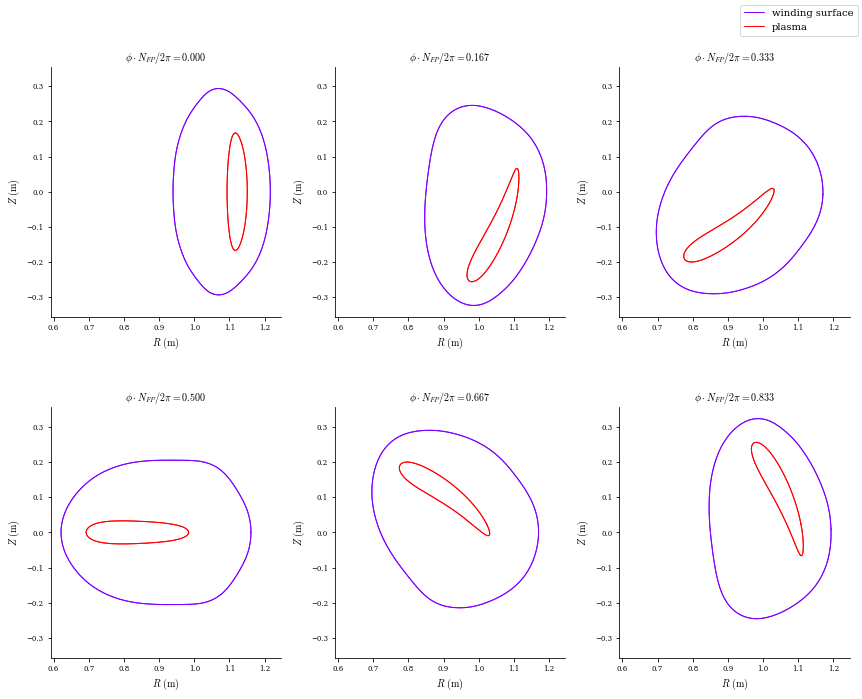

In [3]:
# Plasma surface
eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq = desc.io.load(eqname_QH)[4]

# Create a winding surface as a constant offset surface
#surf_winding = load("surf.h5")

# Create a winding surface as a constant offset surface
winding_surf = load('surf.h5')

# Plot both surfaces
plot_comparison([winding_surf,eq],labels=["winding surface","plasma"],theta=0,rho=np.array(1.0))
#plt.savefig("surfaces.png",dpi = 1200)

In [4]:
kgrid = LinearGrid(M = 70, N = 70, NFP = winding_surf.NFP)
kdata = winding_surf.compute(["n_rho","H_1", "e^zeta_s"], grid = kgrid)

G = np.load("G.npy")
#K_sec = G * cross(kdata["n_rho"], kdata["e^zeta_s"])
K_sec = G * cross(kdata["n_rho"], kdata["H_1"])

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [5]:
egrid = LinearGrid(M = 60, N = 60, NFP = eq.NFP)
edata = eq.compute(["n_rho"], grid = egrid)

#B_s = eq.compute(["B"],grid = egrid)["B"]
B_sec = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid, basis = "rpz" )

#rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2]))
Bn_sec = dot( edata["n_rho"],  B_sec )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [6]:
grid_M = 10
grid_N = 10
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy', B_sec2)

grid_M = 15
grid_N = 15
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy', B_sec2)

grid_M = 20
grid_N = 20
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy', B_sec2)

grid_M = 25
grid_N = 25
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy', B_sec2)

grid_M = 30
grid_N = 30
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy', B_sec2)

grid_M = 40
grid_N = 40
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

grid_M = 50
grid_N = 50
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

grid_M = 60
grid_N = 60
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

grid_M = 70
grid_N = 70
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

grid_M = 80
grid_N = 80
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

grid_M = 100
grid_N = 100
egrid2 = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
B_sec2 = _compute_magnetic_field_from_Current( kgrid, K_sec, winding_surf, eq, egrid2, basis = "rpz" )
np.save('B_sec_'+str(grid_M)+'x'+str(grid_M)+'.npy',B_sec2)

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>